# PreTrain

In [1]:
from model.sswae_dev3 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params, calculate_sharpness
from XAE.sampler import gaus
from XAE.logging_daily import logging_daily
import XAE.fid as fid
from random import sample

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 6

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 25
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.497
[2] loss: 0.389
[3] loss: 0.090
[4] loss: 0.041
[5] loss: 0.024
[6] loss: 0.017
[7] loss: 0.013
[8] loss: 0.011
[9] loss: 0.007
[10] loss: 0.008
[11] loss: 0.007
[12] loss: 0.005
[13] loss: 0.006
[14] loss: 0.006
[15] loss: 0.003
[16] loss: 0.005
[17] loss: 0.005
[18] loss: 0.002
[19] loss: 0.004
[20] loss: 0.003
[21] loss: 0.003
[22] loss: 0.003
[23] loss: 0.003
[24] loss: 0.003
[25] loss: 0.001


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 6])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

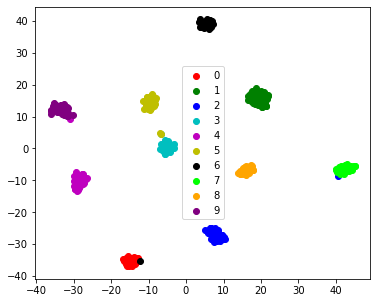

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

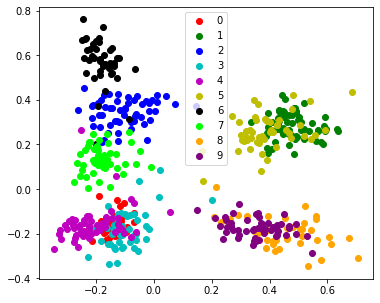

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
# labeled_class = [0,1,2,3,4,5,6,7,8,9]
# train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
# train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
# ys = np.zeros((10, y_dim))
# cs = np.zeros(10)

# for data, condition in train_generator:
#     n = len(data)
#     x = data.to(device)
#     y = condition.to(device)
#     z = embed_condition(embed_data(x))
    
#     labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
#     idxs = labs[idxs].view(n,1).expand(-1, y_dim)
#     cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
#     ys += cc.detach().to('cpu').numpy()
#     cs += counts[labs].detach().to('cpu').numpy()

In [12]:
# w = torch.Tensor(ys.transpose()/cs)
# w

In [13]:
# f1 = nn.Linear(10, y_dim, bias = False)
# f1.weight.data = w
# torch.save(f1.state_dict(), f'./result/f1_{y_dim}.pt')
f1 = nn.Sequential(embed_data, embed_condition)
torch.save(f1.state_dict(), f'./result/f1_dev3_{y_dim}.pt')

# Train

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev3_2.cfg')

['./config/sswae_dev3_2.cfg']

In [4]:
mm = cur_model(cfg, log, device = device)
mm.f1.load_state_dict(torch.load(f'./result/f1_dev3_{y_dim}.pt'))
mm.train()

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 6
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 6
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1539] [01/80]  loss: 2.305143e-01  D: 6.870403e-01  D2: 0.000000e+00  D3: 3.454866e-03
test loss: 1.832531e-01  D: 6.908867e-01  D2: 0.000000e+00  D3: 7.002563e-03


[default |INFO|model.py:1539] [02/80]  loss: 1.736934e-01  D: 6.924743e-01  D2: 0.000000e+00  D3: 8.179572e-03
test loss: 1.636399e-01  D: 7.090250e-01  D2: 0.000000e+00  D3: 7.737311e-03


[default |INFO|model.py:1539] [03/80]  loss: 1.556141e-01  D: 6.922500e-01  D2: 0.000000e+00  D3: 8.098149e-03
test loss: 1.540128e-01  D: 6.906850e-01  D2: 0.000000e+00  D3: 8.354709e-03


[default |INFO|model.py:1539] [04/80]  loss: 1.384033e-01  D: 6.935399e-01  D2: 0.000000e+00  D3: 7.921558e-03
test loss: 1.267848e-01  D: 7.051596e-01  D2: 0.000000e+00  D3: 7.315033e-03


[default |INFO|model.py:1539] [05/80]  loss: 1.219395e-01  D: 6.933090e-01  D2: 0.000000e+00  D3: 8.854448e-03
test loss: 1.201737e-01  D: 6.969786e-01  D2: 0.000000e+00  D3: 1.042389e-02


[default |INFO|model.py:1539] [06/80]  loss: 1.267521e-01  D: 6.946750e-01  D2: 0.000000e+00  D3: 1.270054e-02
test loss: 1.169724e-01  D: 7.094064e-01  D2: 0.000000e+00  D3: 1.221967e-02


[default |INFO|model.py:1539] [07/80]  loss: 1.208297e-01  D: 6.957067e-01  D2: 0.000000e+00  D3: 1.656743e-02
test loss: 1.102226e-01  D: 6.899440e-01  D2: 0.000000e+00  D3: 1.674571e-02


[default |INFO|model.py:1539] [08/80]  loss: 1.079647e-01  D: 6.934720e-01  D2: 0.000000e+00  D3: 1.687090e-02
test loss: 1.098397e-01  D: 6.921358e-01  D2: 0.000000e+00  D3: 1.815042e-02


[default |INFO|model.py:1539] [09/80]  loss: 1.071186e-01  D: 6.941938e-01  D2: 0.000000e+00  D3: 1.728867e-02
test loss: 1.061402e-01  D: 6.864659e-01  D2: 0.000000e+00  D3: 2.038433e-02


[default |INFO|model.py:1539] [10/80]  loss: 1.019286e-01  D: 6.937678e-01  D2: 0.000000e+00  D3: 1.760709e-02
test loss: 9.546902e-02  D: 7.010323e-01  D2: 0.000000e+00  D3: 1.582443e-02


[default |INFO|model.py:1539] [11/80]  loss: 9.645143e-02  D: 6.931770e-01  D2: 0.000000e+00  D3: 1.740486e-02
test loss: 9.658156e-02  D: 6.788339e-01  D2: 0.000000e+00  D3: 2.006120e-02


[default |INFO|model.py:1539] [12/80]  loss: 9.520918e-02  D: 6.936926e-01  D2: 0.000000e+00  D3: 1.639635e-02
test loss: 9.930819e-02  D: 7.112157e-01  D2: 0.000000e+00  D3: 2.072071e-02


[default |INFO|model.py:1539] [13/80]  loss: 9.260448e-02  D: 6.946464e-01  D2: 0.000000e+00  D3: 1.752162e-02
test loss: 8.977254e-02  D: 6.931546e-01  D2: 0.000000e+00  D3: 1.850477e-02


[default |INFO|model.py:1539] [14/80]  loss: 8.917982e-02  D: 6.945168e-01  D2: 0.000000e+00  D3: 1.755705e-02
test loss: 8.681955e-02  D: 6.882814e-01  D2: 0.000000e+00  D3: 1.910950e-02


[default |INFO|model.py:1539] [15/80]  loss: 8.689021e-02  D: 6.940770e-01  D2: 0.000000e+00  D3: 1.706737e-02
test loss: 8.711035e-02  D: 6.801431e-01  D2: 0.000000e+00  D3: 1.574742e-02


[default |INFO|model.py:1539] [16/80]  loss: 8.494231e-02  D: 6.936119e-01  D2: 0.000000e+00  D3: 1.757869e-02
test loss: 8.242185e-02  D: 6.924541e-01  D2: 0.000000e+00  D3: 1.696470e-02


[default |INFO|model.py:1539] [17/80]  loss: 8.375299e-02  D: 6.934902e-01  D2: 0.000000e+00  D3: 1.736307e-02
test loss: 8.260633e-02  D: 6.956409e-01  D2: 0.000000e+00  D3: 1.441894e-02


[default |INFO|model.py:1539] [18/80]  loss: 8.320542e-02  D: 6.938971e-01  D2: 0.000000e+00  D3: 1.704778e-02
test loss: 8.187768e-02  D: 6.983359e-01  D2: 0.000000e+00  D3: 1.783649e-02


[default |INFO|model.py:1539] [19/80]  loss: 8.161153e-02  D: 6.934833e-01  D2: 0.000000e+00  D3: 1.690596e-02
test loss: 8.111986e-02  D: 6.846415e-01  D2: 0.000000e+00  D3: 1.857484e-02


[default |INFO|model.py:1539] [20/80]  loss: 7.946805e-02  D: 6.939192e-01  D2: 0.000000e+00  D3: 1.750226e-02
test loss: 7.932000e-02  D: 6.861378e-01  D2: 0.000000e+00  D3: 1.795093e-02


[default |INFO|model.py:1539] [21/80]  loss: 7.892960e-02  D: 6.943212e-01  D2: 0.000000e+00  D3: 1.714380e-02
test loss: 7.802101e-02  D: 7.017150e-01  D2: 0.000000e+00  D3: 1.565997e-02


[default |INFO|model.py:1539] [22/80]  loss: 7.762966e-02  D: 6.935123e-01  D2: 0.000000e+00  D3: 1.748019e-02
test loss: 7.935657e-02  D: 6.900470e-01  D2: 0.000000e+00  D3: 1.549583e-02


[default |INFO|model.py:1539] [23/80]  loss: 7.709681e-02  D: 6.937699e-01  D2: 0.000000e+00  D3: 1.744965e-02
test loss: 7.736781e-02  D: 6.935237e-01  D2: 0.000000e+00  D3: 1.521300e-02


[default |INFO|model.py:1539] [24/80]  loss: 7.625397e-02  D: 6.935467e-01  D2: 0.000000e+00  D3: 1.717921e-02
test loss: 8.050986e-02  D: 6.968030e-01  D2: 0.000000e+00  D3: 1.738753e-02


[default |INFO|model.py:1539] [25/80]  loss: 7.539806e-02  D: 6.936071e-01  D2: 0.000000e+00  D3: 1.722871e-02
test loss: 7.481468e-02  D: 7.053646e-01  D2: 0.000000e+00  D3: 1.723545e-02


[default |INFO|model.py:1539] [26/80]  loss: 7.437792e-02  D: 6.935291e-01  D2: 0.000000e+00  D3: 1.712060e-02
test loss: 7.628461e-02  D: 6.979392e-01  D2: 0.000000e+00  D3: 1.663111e-02


[default |INFO|model.py:1539] [27/80]  loss: 7.598740e-02  D: 6.942817e-01  D2: 0.000000e+00  D3: 1.681244e-02
test loss: 7.675412e-02  D: 7.099705e-01  D2: 0.000000e+00  D3: 1.891160e-02


[default |INFO|model.py:1539] [28/80]  loss: 7.463986e-02  D: 6.935210e-01  D2: 0.000000e+00  D3: 1.723339e-02
test loss: 7.515765e-02  D: 6.801154e-01  D2: 0.000000e+00  D3: 1.591681e-02


[default |INFO|model.py:1539] [29/80]  loss: 7.526790e-02  D: 6.937734e-01  D2: 0.000000e+00  D3: 1.672445e-02
test loss: 7.690059e-02  D: 6.974243e-01  D2: 0.000000e+00  D3: 1.896872e-02


[default |INFO|model.py:1539] [30/80]  loss: 7.414650e-02  D: 6.936899e-01  D2: 0.000000e+00  D3: 1.655351e-02
test loss: 7.801757e-02  D: 7.071372e-01  D2: 0.000000e+00  D3: 1.950705e-02


[default |INFO|model.py:1539] [31/80]  loss: 7.371412e-02  D: 6.948537e-01  D2: 0.000000e+00  D3: 1.688485e-02
test loss: 7.397906e-02  D: 6.985602e-01  D2: 0.000000e+00  D3: 1.661875e-02


[default |INFO|model.py:1539] [32/80]  loss: 7.290030e-02  D: 6.933271e-01  D2: 0.000000e+00  D3: 1.667029e-02
test loss: 7.781822e-02  D: 6.888106e-01  D2: 0.000000e+00  D3: 1.288437e-02


[default |INFO|model.py:1539] [33/80]  loss: 7.608751e-02  D: 6.937679e-01  D2: 0.000000e+00  D3: 1.617015e-02
test loss: 7.576740e-02  D: 6.980895e-01  D2: 0.000000e+00  D3: 1.910243e-02


[default |INFO|model.py:1539] [34/80]  loss: 7.194771e-02  D: 6.940485e-01  D2: 0.000000e+00  D3: 1.688893e-02
test loss: 7.227954e-02  D: 7.000015e-01  D2: 0.000000e+00  D3: 1.859691e-02


[default |INFO|model.py:1539] [35/80]  loss: 7.304152e-02  D: 6.937311e-01  D2: 0.000000e+00  D3: 1.633033e-02
test loss: 7.777559e-02  D: 6.965249e-01  D2: 0.000000e+00  D3: 1.221235e-02


[default |INFO|model.py:1539] [36/80]  loss: 7.526731e-02  D: 6.946845e-01  D2: 0.000000e+00  D3: 1.638292e-02
test loss: 7.348201e-02  D: 7.071708e-01  D2: 0.000000e+00  D3: 1.872275e-02


[default |INFO|model.py:1539] [37/80]  loss: 7.106807e-02  D: 6.928742e-01  D2: 0.000000e+00  D3: 1.656465e-02
test loss: 7.471877e-02  D: 6.864691e-01  D2: 0.000000e+00  D3: 1.410495e-02


[default |INFO|model.py:1539] [38/80]  loss: 7.245436e-02  D: 6.946456e-01  D2: 0.000000e+00  D3: 1.650706e-02
test loss: 7.400088e-02  D: 7.131715e-01  D2: 0.000000e+00  D3: 1.608629e-02


[default |INFO|model.py:1539] [39/80]  loss: 7.100062e-02  D: 6.934485e-01  D2: 0.000000e+00  D3: 1.650759e-02
test loss: 7.203443e-02  D: 6.852549e-01  D2: 0.000000e+00  D3: 1.467580e-02


[default |INFO|model.py:1539] [40/80]  loss: 6.978893e-02  D: 6.938505e-01  D2: 0.000000e+00  D3: 1.662496e-02
test loss: 7.225877e-02  D: 6.938258e-01  D2: 0.000000e+00  D3: 1.699055e-02


[default |INFO|model.py:1539] [41/80]  loss: 7.055386e-02  D: 6.939959e-01  D2: 0.000000e+00  D3: 1.643390e-02
test loss: 7.163201e-02  D: 6.850704e-01  D2: 0.000000e+00  D3: 1.654318e-02


[default |INFO|model.py:1539] [42/80]  loss: 6.916378e-02  D: 6.934798e-01  D2: 0.000000e+00  D3: 1.652322e-02
test loss: 7.392123e-02  D: 7.020035e-01  D2: 0.000000e+00  D3: 1.743349e-02


[default |INFO|model.py:1539] [43/80]  loss: 6.957447e-02  D: 6.933869e-01  D2: 0.000000e+00  D3: 1.643592e-02
test loss: 7.130313e-02  D: 6.904708e-01  D2: 0.000000e+00  D3: 1.733327e-02


[default |INFO|model.py:1539] [44/80]  loss: 6.910442e-02  D: 6.932800e-01  D2: 0.000000e+00  D3: 1.632327e-02
test loss: 7.140580e-02  D: 6.871933e-01  D2: 0.000000e+00  D3: 1.566071e-02


[default |INFO|model.py:1539] [45/80]  loss: 6.784386e-02  D: 6.932032e-01  D2: 0.000000e+00  D3: 1.657687e-02
test loss: 7.089274e-02  D: 6.976952e-01  D2: 0.000000e+00  D3: 1.787906e-02


[default |INFO|model.py:1539] [46/80]  loss: 6.853317e-02  D: 6.936811e-01  D2: 0.000000e+00  D3: 1.636855e-02
test loss: 7.162024e-02  D: 6.757415e-01  D2: 0.000000e+00  D3: 1.528477e-02


[default |INFO|model.py:1539] [47/80]  loss: 6.804872e-02  D: 6.937684e-01  D2: 0.000000e+00  D3: 1.635896e-02
test loss: 7.253664e-02  D: 6.919808e-01  D2: 0.000000e+00  D3: 1.525519e-02


[default |INFO|model.py:1539] [48/80]  loss: 6.817136e-02  D: 6.928716e-01  D2: 0.000000e+00  D3: 1.618563e-02
test loss: 7.039375e-02  D: 6.881430e-01  D2: 0.000000e+00  D3: 1.622697e-02


[default |INFO|model.py:1539] [49/80]  loss: 6.804248e-02  D: 6.932957e-01  D2: 0.000000e+00  D3: 1.614365e-02
test loss: 7.084618e-02  D: 6.800495e-01  D2: 0.000000e+00  D3: 1.611389e-02


[default |INFO|model.py:1539] [50/80]  loss: 6.888673e-02  D: 6.943237e-01  D2: 0.000000e+00  D3: 1.613242e-02
test loss: 7.107964e-02  D: 6.819383e-01  D2: 0.000000e+00  D3: 1.626311e-02


[default |INFO|model.py:1539] [51/80]  loss: 6.778970e-02  D: 6.939566e-01  D2: 0.000000e+00  D3: 1.621780e-02
test loss: 7.270625e-02  D: 6.944893e-01  D2: 0.000000e+00  D3: 1.588220e-02


[default |INFO|model.py:1539] [52/80]  loss: 6.710164e-02  D: 6.930194e-01  D2: 0.000000e+00  D3: 1.634188e-02
test loss: 7.010479e-02  D: 6.922933e-01  D2: 0.000000e+00  D3: 1.608411e-02


[default |INFO|model.py:1539] [53/80]  loss: 6.742136e-02  D: 6.936977e-01  D2: 0.000000e+00  D3: 1.624134e-02
test loss: 6.955031e-02  D: 6.911781e-01  D2: 0.000000e+00  D3: 1.672628e-02


[default |INFO|model.py:1539] [54/80]  loss: 6.692257e-02  D: 6.934115e-01  D2: 0.000000e+00  D3: 1.632566e-02
test loss: 7.041303e-02  D: 6.824485e-01  D2: 0.000000e+00  D3: 1.572302e-02


[default |INFO|model.py:1539] [55/80]  loss: 6.723061e-02  D: 6.935555e-01  D2: 0.000000e+00  D3: 1.599495e-02
test loss: 7.174240e-02  D: 6.938498e-01  D2: 0.000000e+00  D3: 1.702895e-02


[default |INFO|model.py:1539] [56/80]  loss: 6.690306e-02  D: 6.939270e-01  D2: 0.000000e+00  D3: 1.619332e-02
test loss: 6.899583e-02  D: 7.018694e-01  D2: 0.000000e+00  D3: 1.612480e-02


[default |INFO|model.py:1539] [57/80]  loss: 6.597780e-02  D: 6.930034e-01  D2: 0.000000e+00  D3: 1.630757e-02
test loss: 6.986781e-02  D: 6.966397e-01  D2: 0.000000e+00  D3: 1.579145e-02


[default |INFO|model.py:1539] [58/80]  loss: 6.581585e-02  D: 6.933356e-01  D2: 0.000000e+00  D3: 1.616802e-02
test loss: 6.922112e-02  D: 6.840326e-01  D2: 0.000000e+00  D3: 1.604801e-02


[default |INFO|model.py:1539] [59/80]  loss: 6.601455e-02  D: 6.933869e-01  D2: 0.000000e+00  D3: 1.618823e-02
test loss: 6.818796e-02  D: 6.957770e-01  D2: 0.000000e+00  D3: 1.632555e-02


[default |INFO|model.py:1539] [60/80]  loss: 6.566107e-02  D: 6.933691e-01  D2: 0.000000e+00  D3: 1.615805e-02
test loss: 6.990192e-02  D: 6.934455e-01  D2: 0.000000e+00  D3: 1.534336e-02


[default |INFO|model.py:1539] [61/80]  loss: 6.573790e-02  D: 6.935939e-01  D2: 0.000000e+00  D3: 1.614474e-02
test loss: 6.994740e-02  D: 7.030551e-01  D2: 0.000000e+00  D3: 1.688445e-02


[default |INFO|model.py:1539] [62/80]  loss: 6.561128e-02  D: 6.934176e-01  D2: 0.000000e+00  D3: 1.602390e-02
test loss: 6.865067e-02  D: 6.943846e-01  D2: 0.000000e+00  D3: 1.662244e-02


[default |INFO|model.py:1539] [63/80]  loss: 6.592875e-02  D: 6.932574e-01  D2: 0.000000e+00  D3: 1.593316e-02
test loss: 6.984085e-02  D: 6.952110e-01  D2: 0.000000e+00  D3: 1.523283e-02


[default |INFO|model.py:1539] [64/80]  loss: 6.552109e-02  D: 6.932043e-01  D2: 0.000000e+00  D3: 1.601729e-02
test loss: 7.012878e-02  D: 6.922887e-01  D2: 0.000000e+00  D3: 1.661595e-02


[default |INFO|model.py:1539] [65/80]  loss: 6.546732e-02  D: 6.931652e-01  D2: 0.000000e+00  D3: 1.590968e-02
test loss: 6.909026e-02  D: 6.833936e-01  D2: 0.000000e+00  D3: 1.673302e-02


[default |INFO|model.py:1539] [66/80]  loss: 6.517696e-02  D: 6.938149e-01  D2: 0.000000e+00  D3: 1.594428e-02
test loss: 6.938107e-02  D: 6.889337e-01  D2: 0.000000e+00  D3: 1.537685e-02


[default |INFO|model.py:1539] [67/80]  loss: 6.482061e-02  D: 6.931313e-01  D2: 0.000000e+00  D3: 1.590090e-02
test loss: 6.853711e-02  D: 6.969534e-01  D2: 0.000000e+00  D3: 1.592025e-02


[default |INFO|model.py:1539] [68/80]  loss: 6.464899e-02  D: 6.930898e-01  D2: 0.000000e+00  D3: 1.592926e-02
test loss: 6.856974e-02  D: 6.999134e-01  D2: 0.000000e+00  D3: 1.606885e-02


[default |INFO|model.py:1539] [69/80]  loss: 6.468931e-02  D: 6.940879e-01  D2: 0.000000e+00  D3: 1.587223e-02
test loss: 6.951680e-02  D: 7.006865e-01  D2: 0.000000e+00  D3: 1.502135e-02


[default |INFO|model.py:1539] [70/80]  loss: 6.468882e-02  D: 6.929383e-01  D2: 0.000000e+00  D3: 1.587234e-02
test loss: 6.886668e-02  D: 7.003346e-01  D2: 0.000000e+00  D3: 1.542607e-02


[default |INFO|model.py:1539] [71/80]  loss: 6.475505e-02  D: 6.930092e-01  D2: 0.000000e+00  D3: 1.566075e-02
test loss: 6.827740e-02  D: 6.885622e-01  D2: 0.000000e+00  D3: 1.652692e-02


[default |INFO|model.py:1539] [72/80]  loss: 6.428407e-02  D: 6.938078e-01  D2: 0.000000e+00  D3: 1.585078e-02
test loss: 6.874543e-02  D: 6.918963e-01  D2: 0.000000e+00  D3: 1.487136e-02


[default |INFO|model.py:1539] [73/80]  loss: 6.421782e-02  D: 6.929974e-01  D2: 0.000000e+00  D3: 1.576800e-02
test loss: 6.802998e-02  D: 6.956579e-01  D2: 0.000000e+00  D3: 1.573248e-02


[default |INFO|model.py:1539] [74/80]  loss: 6.461752e-02  D: 6.934749e-01  D2: 0.000000e+00  D3: 1.564263e-02
test loss: 6.860127e-02  D: 6.845655e-01  D2: 0.000000e+00  D3: 1.484353e-02


[default |INFO|model.py:1539] [75/80]  loss: 6.438592e-02  D: 6.937312e-01  D2: 0.000000e+00  D3: 1.576198e-02
test loss: 6.857509e-02  D: 6.723778e-01  D2: 0.000000e+00  D3: 1.637212e-02


[default |INFO|model.py:1539] [76/80]  loss: 6.423690e-02  D: 6.938161e-01  D2: 0.000000e+00  D3: 1.573452e-02
test loss: 6.861650e-02  D: 6.990717e-01  D2: 0.000000e+00  D3: 1.554331e-02


[default |INFO|model.py:1539] [77/80]  loss: 6.368876e-02  D: 6.928078e-01  D2: 0.000000e+00  D3: 1.568325e-02
test loss: 6.748233e-02  D: 6.943913e-01  D2: 0.000000e+00  D3: 1.631333e-02


[default |INFO|model.py:1539] [78/80]  loss: 6.386229e-02  D: 6.935405e-01  D2: 0.000000e+00  D3: 1.580286e-02
test loss: 6.892269e-02  D: 6.967305e-01  D2: 0.000000e+00  D3: 1.609675e-02


[default |INFO|model.py:1539] [79/80]  loss: 6.400715e-02  D: 6.933942e-01  D2: 0.000000e+00  D3: 1.576676e-02
test loss: 6.814354e-02  D: 6.955238e-01  D2: 0.000000e+00  D3: 1.555324e-02


[default |INFO|model.py:1539] [80/80]  loss: 6.390352e-02  D: 6.935503e-01  D2: 0.000000e+00  D3: 1.566748e-02
test loss: 6.998924e-02  D: 6.923971e-01  D2: 0.000000e+00  D3: 1.562223e-02


[default |INFO|model.py:1609] Training Finished!
[default |INFO|model.py:1610] Elapsed time: 4473.445s


# Test

In [5]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [6]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [7]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

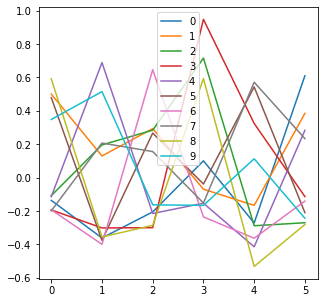

In [8]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

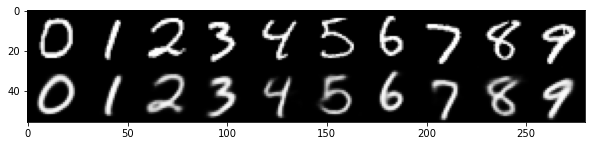

In [9]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [10]:
exn = 5

In [11]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

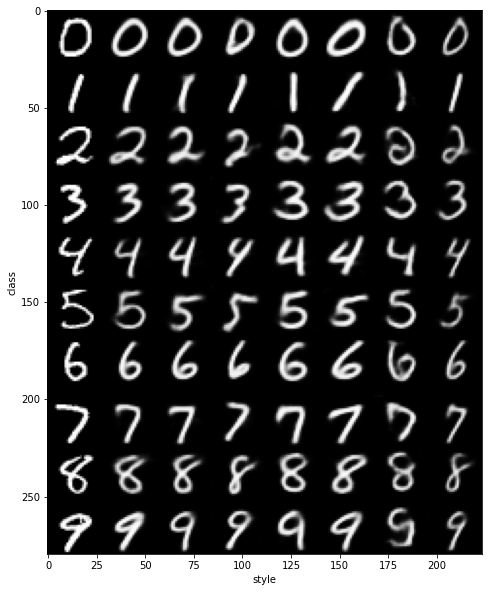

In [12]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [13]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

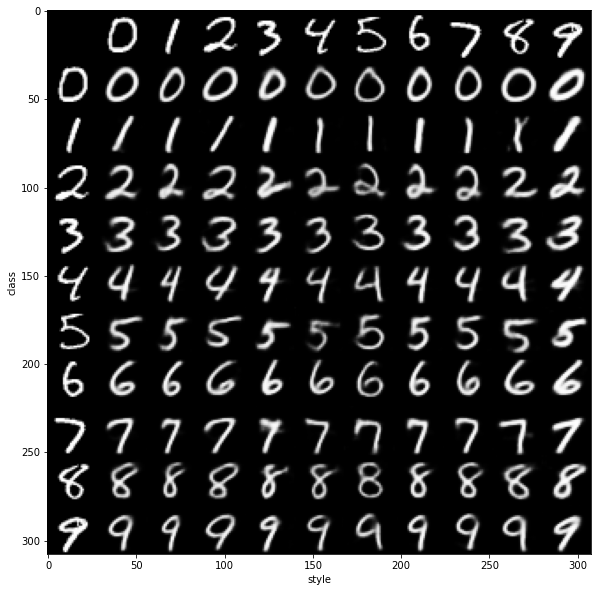

In [14]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()